## 📦 Step 1: Install Dependencies

Installing PyTorch, visualization libraries, and other dependencies.

In [1]:
# Install required packages
import sys
import warnings
warnings.filterwarnings('ignore')

print("📦 Installing dependencies for Floor Plan Generator...")
print("   This may take 1-2 minutes...\n")

# Install packages (no PyTorch needed for custom generator)
!pip install --upgrade --force-reinstall matplotlib numpy networkx Pillow

print("\n✅ Installation complete!")
print("\n⚠️  IMPORTANT: Restart kernel after first install, then skip this cell")

📦 Installing dependencies for Floor Plan Generator...
   This may take 1-2 minutes...

  Using cached matplotlib-3.10.7-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached numpy-2.3.5-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached pillow-12.0.0-cp313-cp313-win_amd64.whl.metadata (9.0 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp313-cp313-win_amd64.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached matplotlib-3.10.7-cp313-cp313-win_amd64.whl (8.1 

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.5 which is incompatible.


## 📂 Step 2: Load Requirements from Phase 1

Select and load the requirements JSON file created in Phase 1.

In [1]:
import json
import os
from pathlib import Path
from datetime import datetime

# Find all requirement files
# Since notebook is in notebooks/ folder, look in current directory
req_dir = Path("generated_requirements")

if req_dir.exists():
    req_files = sorted(list(req_dir.glob("requirements_*.json")), reverse=True)
    
    if req_files:
        print(f"📁 Found {len(req_files)} requirement file(s):\n")
        for i, file in enumerate(req_files, 1):
            file_time = datetime.fromtimestamp(file.stat().st_mtime)
            print(f"   {i}. {file.name} (created: {file_time.strftime('%Y-%m-%d %H:%M:%S')})")
        
        # Load the most recent file by default
        selected_file = req_files[0]
        print(f"\n✅ Loading most recent: {selected_file.name}")
        
        with open(selected_file, 'r') as f:
            requirements = json.load(f)
        
        print("\n📋 Requirements Summary:")
        print(f"   • Bungalow Type: {requirements.get('bungalow_type', 'Not specified')}")
        print(f"   • Land Area: {requirements.get('land_area', {}).get('value', 'N/A')} {requirements.get('land_area', {}).get('unit', '')}")
        print(f"   • Bedrooms: {requirements.get('bedrooms', {}).get('count', 'N/A')}")
        print(f"   • Bathrooms: {requirements.get('bathrooms', {}).get('count', 'N/A')}")
        print(f"   • Kitchen: {requirements.get('kitchen', {}).get('type', 'N/A')}")
        print(f"   • Parking: {requirements.get('parking', {}).get('four_wheeler', 0)} cars, {requirements.get('parking', {}).get('two_wheeler', 0)} bikes")
        
    else:
        print("❌ No requirement files found!")
        print("   Please complete Phase 1 first to generate requirements.")
        requirements = None
else:
    print("❌ Requirements directory not found!")
    print(f"   Expected location: {req_dir.absolute()}")
    print("   Please complete Phase 1 first.")
    requirements = None

📁 Found 1 requirement file(s):

   1. requirements_20251119_151552.json (created: 2025-11-19 15:15:52)

✅ Loading most recent: requirements_20251119_151552.json

📋 Requirements Summary:
   • Bungalow Type: single-story
   • Land Area: None None
   • Bedrooms: 2
   • Bathrooms: 2
   • Kitchen: open
   • Parking: 1 cars, 2 bikes


## 🏗️ Step 3: Custom Floor Plan Generator

Creating a custom algorithmic floor plan generator based on your requirements.
This uses smart layout algorithms instead of a pre-trained model.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import random

# Room class mapping
ROOM_CLASS = {
    "living_room": 1, 
    "kitchen": 2, 
    "bedroom": 3, 
    "bathroom": 4, 
    "missing": 5, 
    "closet": 6, 
    "balcony": 7, 
    "corridor": 8, 
    "dining_room": 9, 
    "laundry_room": 10
}

CLASS_TO_ROOM = {v: k for k, v in ROOM_CLASS.items()}

# Room size preferences (relative units)
ROOM_SIZES = {
    "living_room": (8, 10),    # width, height in grid units
    "kitchen": (6, 6),
    "bedroom": (7, 8),
    "bathroom": (4, 5),
    "dining_room": (6, 7),
    "balcony": (8, 3),
    "corridor": (3, 4),
    "laundry_room": (4, 4),
    "closet": (3, 3)
}

class CustomFloorPlanGenerator:
    """Custom algorithmic floor plan generator"""
    
    def __init__(self, grid_size=64):
        self.grid_size = grid_size
        self.grid = None
        
    def create_blank_canvas(self):
        """Create empty floor plan canvas"""
        self.grid = np.zeros((self.grid_size, self.grid_size), dtype=int)
        return self.grid
    
    def place_room(self, room_type, x, y, width, height, allow_overlap=False):
        """Place a room on the grid"""
        room_id = ROOM_CLASS.get(room_type, 0)
        
        # Ensure bounds
        x = max(0, min(x, self.grid_size - width))
        y = max(0, min(y, self.grid_size - height))
        
        # Check for overlap
        if not allow_overlap:
            if np.any(self.grid[y:y+height, x:x+width] != 0):
                return False
        
        # Place room
        self.grid[y:y+height, x:x+width] = room_id
        return True
    
    def place_room_smart(self, room_type, preferred_x=None, preferred_y=None, tries=50):
        """Intelligently place a room with multiple attempts"""
        base_width, base_height = ROOM_SIZES.get(room_type, (5, 5))
        
        # Add some variation
        width = base_width + random.randint(-1, 1)
        height = base_height + random.randint(-1, 1)
        width = max(3, min(width, self.grid_size // 3))
        height = max(3, min(height, self.grid_size // 3))
        
        for attempt in range(tries):
            if preferred_x is not None and preferred_y is not None and attempt < 10:
                # Try preferred location first
                x = preferred_x + random.randint(-2, 2)
                y = preferred_y + random.randint(-2, 2)
            else:
                # Random placement
                x = random.randint(2, self.grid_size - width - 2)
                y = random.randint(2, self.grid_size - height - 2)
            
            if self.place_room(room_type, x, y, width, height):
                return (x, y, width, height)
        
        return None
    
    def find_adjacent_position(self, existing_room, room_type, direction='right'):
        """Find position adjacent to an existing room"""
        if existing_room is None:
            return None
        
        x, y, w, h = existing_room
        new_w, new_h = ROOM_SIZES.get(room_type, (5, 5))
        
        # Try different directions
        positions = []
        if direction == 'right':
            positions.append((x + w + 1, y))
        elif direction == 'left':
            positions.append((x - new_w - 1, y))
        elif direction == 'below':
            positions.append((x, y + h + 1))
        elif direction == 'above':
            positions.append((x, y - new_h - 1))
        else:
            # Try all directions
            positions = [
                (x + w + 1, y),           # right
                (x - new_w - 1, y),       # left
                (x, y + h + 1),           # below
                (x, y - new_h - 1)        # above
            ]
        
        for px, py in positions:
            if 0 <= px < self.grid_size - new_w and 0 <= py < self.grid_size - new_h:
                if np.all(self.grid[py:py+new_h, px:px+new_w] == 0):
                    return (px, py)
        
        return None
    
    def generate_layout(self, room_list, layout_style='traditional'):
        """Generate complete floor plan layout"""
        self.create_blank_canvas()
        placed_rooms = {}
        
        # Separate rooms by priority
        priority_rooms = []
        standard_rooms = []
        utility_rooms = []
        
        for room in room_list:
            if room == 'living_room':
                priority_rooms.insert(0, room)
            elif room in ['bedroom', 'bathroom']:
                standard_rooms.append(room)
            else:
                utility_rooms.append(room)
        
        all_rooms = priority_rooms + standard_rooms + utility_rooms
        
        # Place living room first (central)
        if 'living_room' in all_rooms:
            center_x = self.grid_size // 3
            center_y = self.grid_size // 3
            living_pos = self.place_room_smart('living_room', center_x, center_y)
            if living_pos:
                placed_rooms['living_room'] = living_pos
                all_rooms.remove('living_room')
        
        # Place kitchen adjacent to living room
        if 'kitchen' in all_rooms and 'living_room' in placed_rooms:
            kitchen_x, kitchen_y = self.find_adjacent_position(
                placed_rooms['living_room'], 'kitchen', 'right'
            ) or (None, None)
            
            if kitchen_x is not None:
                kitchen_pos = self.place_room_smart('kitchen', kitchen_x, kitchen_y)
                if kitchen_pos:
                    placed_rooms['kitchen'] = kitchen_pos
                    all_rooms.remove('kitchen')
        
        # Place remaining rooms
        for room_type in all_rooms:
            # Try to place near related rooms
            anchor_room = None
            
            if room_type == 'dining_room' and 'kitchen' in placed_rooms:
                anchor_room = placed_rooms['kitchen']
            elif room_type == 'bathroom' and 'bedroom' in [r for r in placed_rooms.keys()]:
                # Find first bedroom
                for key in placed_rooms.keys():
                    if 'bedroom' in key:
                        anchor_room = placed_rooms[key]
                        break
            elif room_type == 'balcony' and 'living_room' in placed_rooms:
                anchor_room = placed_rooms['living_room']
            
            if anchor_room:
                adj_pos = self.find_adjacent_position(anchor_room, room_type, direction='any')
                if adj_pos:
                    room_pos = self.place_room_smart(room_type, adj_pos[0], adj_pos[1])
                else:
                    room_pos = self.place_room_smart(room_type)
            else:
                room_pos = self.place_room_smart(room_type)
            
            if room_pos:
                # Handle multiple instances (bedrooms, bathrooms)
                key = room_type
                counter = 1
                while key in placed_rooms:
                    counter += 1
                    key = f"{room_type}_{counter}"
                placed_rooms[key] = room_pos
        
        return self.grid, placed_rooms
    
    def add_walls_and_doors(self):
        """Add walls around rooms and door openings"""
        # Create a copy for wall layer
        walls = np.copy(self.grid)
        
        # Add exterior walls (simple boundary)
        walls[0, :] = 5  # Top wall
        walls[-1, :] = 5  # Bottom wall
        walls[:, 0] = 5  # Left wall
        walls[:, -1] = 5  # Right wall
        
        return walls

print("✅ Custom Floor Plan Generator initialized!")
print("   This generator uses smart algorithmic placement")
print("   No pre-trained model needed!")

generator = CustomFloorPlanGenerator(grid_size=64)

✅ Custom Floor Plan Generator initialized!
   This generator uses smart algorithmic placement
   No pre-trained model needed!


## 🔄 Step 4: Convert Requirements to Room Graph

Transform the text requirements into a structured room graph that House-GAN can understand.

🔄 Converting requirements to room graph...

✅ Room graph created successfully!


C:\Users\k64169477\AppData\Local\Temp\ipykernel_25268\733106279.py:175: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


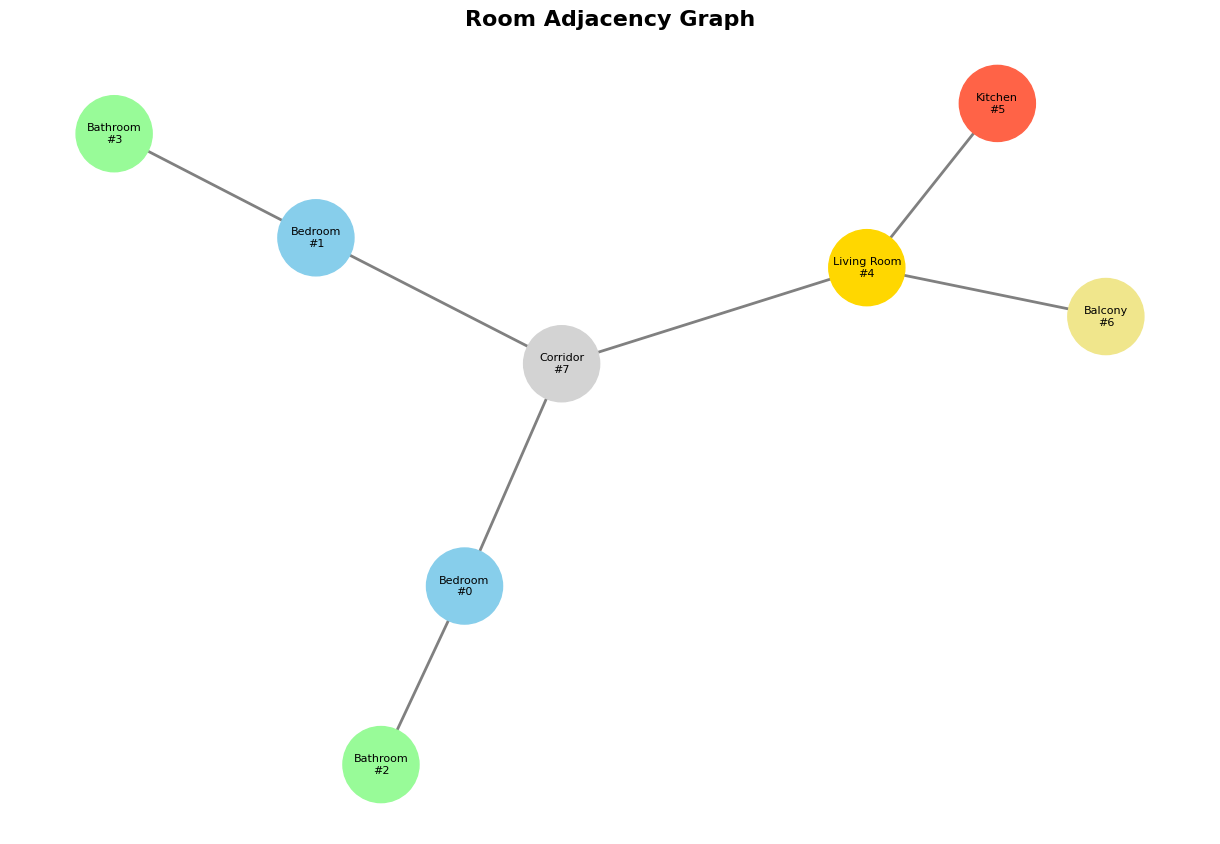


📊 Graph Statistics:
   • Total Rooms: 8
   • Room Types: 6
   • Connections: 7

📋 Room List:
   1. Bedroom
   2. Bedroom
   3. Bathroom
   4. Bathroom
   5. Living Room
   6. Kitchen
   7. Balcony
   8. Corridor


In [3]:
import networkx as nx
from typing import Dict, List, Tuple

class RequirementToGraphConverter:
    """Converts bungalow requirements to House-GAN room graph"""
    
    def __init__(self, requirements: Dict):
        self.req = requirements
        self.rooms = []
        self.graph = nx.Graph()
        
    def extract_rooms(self) -> List[str]:
        """Extract list of rooms from requirements"""
        rooms = []
        
        # Add bedrooms
        bedroom_count = self.req.get('bedrooms', {}).get('count', 0)
        if bedroom_count:
            for i in range(bedroom_count):
                room_name = f"bedroom_{i+1}" if bedroom_count > 1 else "bedroom"
                rooms.append("bedroom")
        
        # Add bathrooms
        bathroom_count = self.req.get('bathrooms', {}).get('count', 0)
        if bathroom_count:
            for i in range(bathroom_count):
                rooms.append("bathroom")
        
        # Add living room
        if self.req.get('living_room', {}).get('required', True):
            rooms.append("living_room")
        
        # Add kitchen
        if self.req.get('kitchen', {}).get('type'):
            rooms.append("kitchen")
        
        # Add dining room
        dining_type = self.req.get('dining_room', {}).get('type', '')
        if dining_type == 'separate':
            rooms.append("dining_room")
        
        # Add additional rooms
        additional = self.req.get('additional_rooms', {})
        if additional.get('laundry'):
            rooms.append("laundry_room")
        if additional.get('study') or additional.get('guest_room'):
            rooms.append("bedroom")  # Treat as bedroom for now
        if additional.get('store_room'):
            rooms.append("closet")
        
        # Add outdoor spaces
        outdoor = self.req.get('outdoor_spaces', {})
        if outdoor.get('balcony'):
            rooms.append("balcony")
        
        # Add corridor for connectivity
        if len(rooms) > 4:  # Add corridor for larger homes
            rooms.append("corridor")
        
        self.rooms = rooms
        return rooms
    
    def build_adjacency_graph(self) -> nx.Graph:
        """Build room adjacency graph based on typical layouts"""
        G = nx.Graph()
        
        # Add all rooms as nodes
        for i, room in enumerate(self.rooms):
            G.add_node(i, room_type=room)
        
        # Define typical adjacencies
        room_indices = {room: [] for room in set(self.rooms)}
        for i, room in enumerate(self.rooms):
            room_indices[room].append(i)
        
        # Connect living room to other spaces (central hub)
        if 'living_room' in room_indices:
            living_idx = room_indices['living_room'][0]
            
            # Living room connects to kitchen
            if 'kitchen' in room_indices:
                G.add_edge(living_idx, room_indices['kitchen'][0])
            
            # Living room connects to dining
            if 'dining_room' in room_indices:
                G.add_edge(living_idx, room_indices['dining_room'][0])
            
            # Living room connects to corridor (if exists)
            if 'corridor' in room_indices:
                corridor_idx = room_indices['corridor'][0]
                G.add_edge(living_idx, corridor_idx)
        
        # Connect bedrooms to bathrooms and corridor
        if 'bedroom' in room_indices and 'bathroom' in room_indices:
            bedrooms = room_indices['bedroom']
            bathrooms = room_indices['bathroom']
            
            # Connect each bedroom to nearest bathroom
            for i, br_idx in enumerate(bedrooms):
                bath_idx = bathrooms[min(i, len(bathrooms)-1)]
                G.add_edge(br_idx, bath_idx)
                
                # Connect bedrooms to corridor if exists
                if 'corridor' in room_indices:
                    G.add_edge(br_idx, room_indices['corridor'][0])
        
        # Connect kitchen to dining and laundry
        if 'kitchen' in room_indices:
            kitchen_idx = room_indices['kitchen'][0]
            
            if 'dining_room' in room_indices:
                G.add_edge(kitchen_idx, room_indices['dining_room'][0])
            
            if 'laundry_room' in room_indices:
                G.add_edge(kitchen_idx, room_indices['laundry_room'][0])
        
        # Connect balcony to living room or bedroom
        if 'balcony' in room_indices:
            balcony_idx = room_indices['balcony'][0]
            if 'living_room' in room_indices:
                G.add_edge(balcony_idx, room_indices['living_room'][0])
            elif 'bedroom' in room_indices:
                G.add_edge(balcony_idx, room_indices['bedroom'][0])
        
        self.graph = G
        return G
    
    def get_room_type_vector(self) -> List[int]:
        """Get room type class labels"""
        return [ROOM_CLASS[room] for room in self.rooms]
    
    def get_adjacency_matrix(self) -> np.ndarray:
        """Get adjacency matrix from graph"""
        return nx.to_numpy_array(self.graph)
    
    def visualize_graph(self):
        """Visualize the room graph"""
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(self.graph, seed=42)
        
        # Color map for rooms
        color_map = {
            "living_room": "#FFD700",
            "kitchen": "#FF6347", 
            "bedroom": "#87CEEB",
            "bathroom": "#98FB98",
            "dining_room": "#FFA500",
            "laundry_room": "#DDA0DD",
            "balcony": "#F0E68C",
            "corridor": "#D3D3D3",
            "closet": "#C0C0C0"
        }
        
        node_colors = [color_map.get(self.graph.nodes[node]['room_type'], '#CCCCCC') 
                      for node in self.graph.nodes()]
        
        nx.draw(self.graph, pos, 
                node_color=node_colors,
                node_size=3000,
                font_size=10,
                font_weight='bold',
                with_labels=False,
                edge_color='gray',
                width=2)
        
        # Add labels with room names
        labels = {node: f"{self.graph.nodes[node]['room_type'].replace('_', ' ').title()}\n#{node}" 
                 for node in self.graph.nodes()}
        nx.draw_networkx_labels(self.graph, pos, labels, font_size=8)
        
        plt.title("Room Adjacency Graph", fontsize=16, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        print(f"\n📊 Graph Statistics:")
        print(f"   • Total Rooms: {len(self.rooms)}")
        print(f"   • Room Types: {len(set(self.rooms))}")
        print(f"   • Connections: {self.graph.number_of_edges()}")
        print(f"\n📋 Room List:")
        for i, room in enumerate(self.rooms):
            print(f"   {i+1}. {room.replace('_', ' ').title()}")

# Convert requirements to graph
if requirements and requirements is not None:
    print("🔄 Converting requirements to room graph...\n")
    
    converter = RequirementToGraphConverter(requirements)
    rooms = converter.extract_rooms()
    graph = converter.build_adjacency_graph()
    
    print("✅ Room graph created successfully!")
    converter.visualize_graph()
else:
    print("❌ No requirements loaded. Please run Step 2 first.")
    converter = None

## 🎨 Step 5: Generate Floor Plans

Generate multiple floor plan variations using the House-GAN model.

🎨 Generating floor plan variations...
   Using custom algorithmic generator...

📋 Generating layouts for 8 rooms:
   1. Bedroom
   2. Bedroom
   3. Bathroom
   4. Bathroom
   5. Living Room
   6. Kitchen
   7. Balcony
   8. Corridor

✅ Generated 6 floor plan variations!
   Floor plan size: 64x64 grid



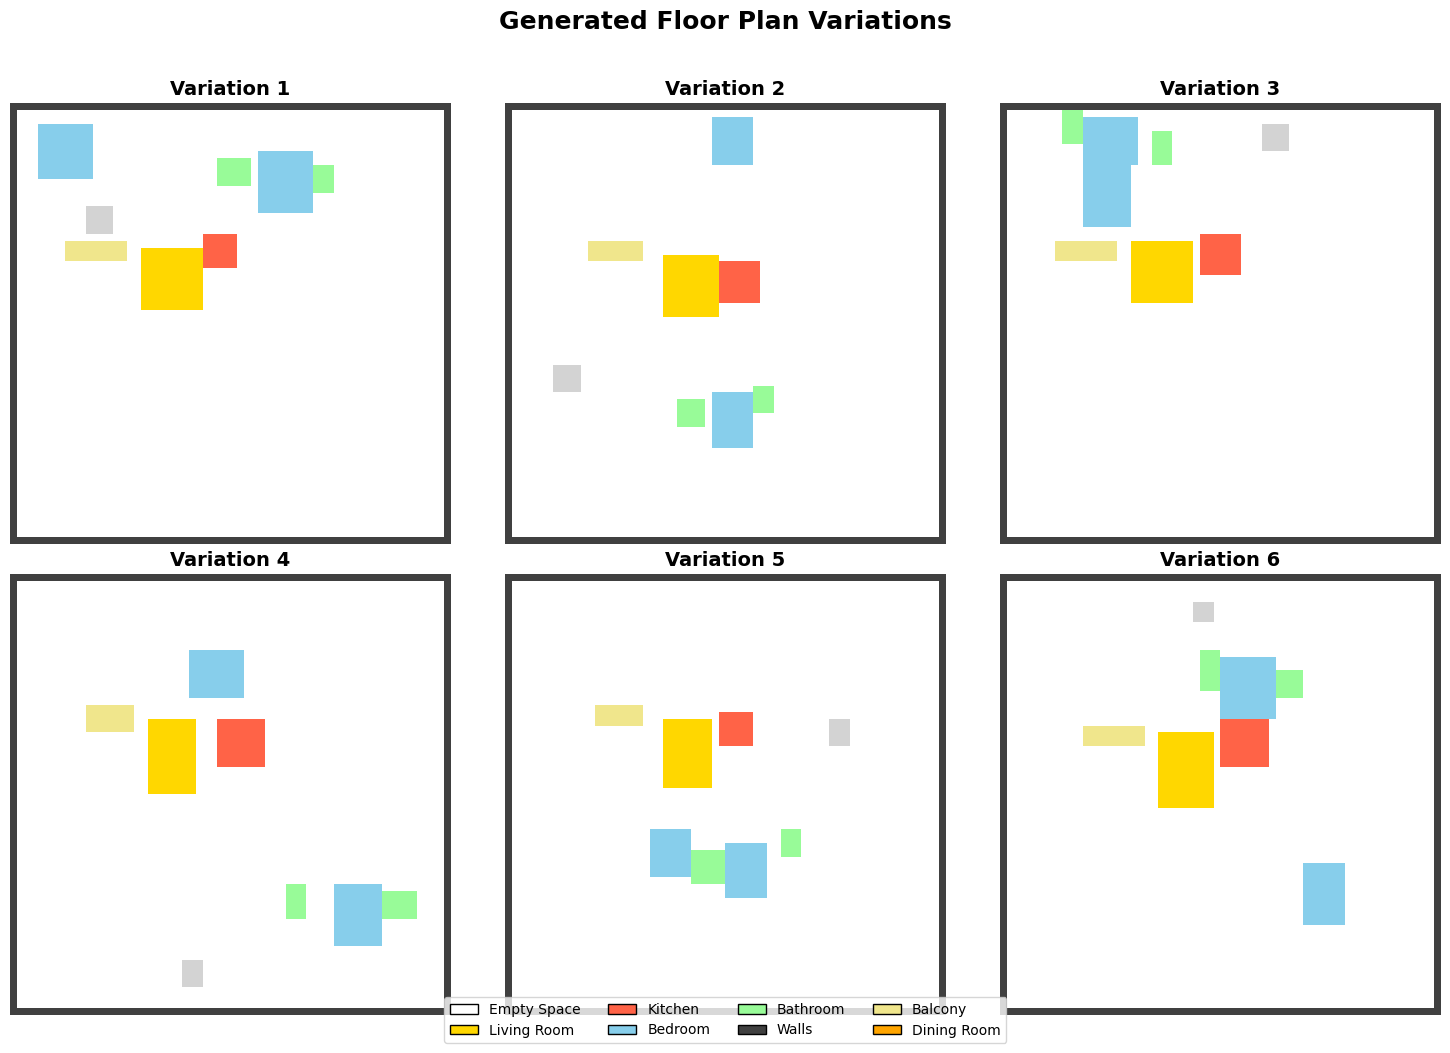

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap

def generate_multiple_floorplans(generator, room_list, num_variations=6):
    """Generate multiple floor plan variations"""
    floorplans = []
    
    for i in range(num_variations):
        # Set different random seed for each variation
        random.seed(42 + i * 10)
        np.random.seed(42 + i * 10)
        
        # Generate layout
        layout, placed_rooms = generator.generate_layout(room_list)
        
        # Add walls
        final_layout = generator.add_walls_and_doors()
        
        floorplans.append(final_layout)
    
    return floorplans

def visualize_floorplans(floorplans, num_cols=3):
    """Visualize generated floor plans"""
    
    num_plans = len(floorplans)
    num_rows = (num_plans + num_cols - 1) // num_cols
    
    # Color map for rooms
    colors = [
        '#FFFFFF',  # 0: Background/Empty
        '#FFD700',  # 1: Living room
        '#FF6347',  # 2: Kitchen
        '#87CEEB',  # 3: Bedroom
        '#98FB98',  # 4: Bathroom
        '#404040',  # 5: Walls
        '#C0C0C0',  # 6: Closet
        '#F0E68C',  # 7: Balcony
        '#D3D3D3',  # 8: Corridor
        '#FFA500',  # 9: Dining room
        '#DDA0DD',  # 10: Laundry room
    ]
    cmap = ListedColormap(colors)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))
    if num_plans == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for idx, (plan, ax) in enumerate(zip(floorplans, axes)):
        # Display
        im = ax.imshow(plan, cmap=cmap, vmin=0, vmax=10, interpolation='nearest')
        ax.set_title(f"Variation {idx+1}", fontsize=14, fontweight='bold')
        ax.axis('off')
        
        # Add grid for better visualization
        ax.set_aspect('equal')
    
    # Hide extra subplots
    for idx in range(num_plans, len(axes)):
        axes[idx].axis('off')
    
    # Add legend
    legend_elements = [
        patches.Patch(facecolor=colors[0], edgecolor='black', label='Empty Space'),
        patches.Patch(facecolor=colors[1], edgecolor='black', label='Living Room'),
        patches.Patch(facecolor=colors[2], edgecolor='black', label='Kitchen'),
        patches.Patch(facecolor=colors[3], edgecolor='black', label='Bedroom'),
        patches.Patch(facecolor=colors[4], edgecolor='black', label='Bathroom'),
        patches.Patch(facecolor=colors[5], edgecolor='black', label='Walls'),
        patches.Patch(facecolor=colors[7], edgecolor='black', label='Balcony'),
        patches.Patch(facecolor=colors[9], edgecolor='black', label='Dining Room'),
    ]
    
    fig.legend(handles=legend_elements, loc='lower center', ncol=4, 
              fontsize=10, bbox_to_anchor=(0.5, -0.02))
    
    plt.suptitle("Generated Floor Plan Variations", fontsize=18, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Generate floor plans
if generator and converter:
    print("🎨 Generating floor plan variations...")
    print("   Using custom algorithmic generator...\n")
    
    try:
        rooms = converter.rooms
        
        print(f"📋 Generating layouts for {len(rooms)} rooms:")
        for i, room in enumerate(rooms, 1):
            print(f"   {i}. {room.replace('_', ' ').title()}")
        
        num_variations = 6  # Generate 6 variations
        
        floorplans = generate_multiple_floorplans(
            generator,
            rooms,
            num_variations=num_variations
        )
        
        print(f"\n✅ Generated {num_variations} floor plan variations!")
        print(f"   Floor plan size: {floorplans[0].shape[0]}x{floorplans[0].shape[1]} grid\n")
        
        visualize_floorplans(floorplans)
        
    except Exception as e:
        print(f"❌ Error generating floor plans: {e}")
        import traceback
        traceback.print_exc()
        floorplans = None
else:
    print("❌ Generator or converter not initialized. Please run previous steps.")
    floorplans = None

## 💾 Step 6: Export Floor Plans

Save the generated floor plans as images for Phase 3 (3D visualization).

In [6]:
from PIL import Image
import os

def save_floorplans(floorplans, output_dir="generated_floorplans"):
    """Save floor plans as images"""
    
    os.makedirs(output_dir, exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    saved_files = []
    
    # Color map (RGB values)
    colors = np.array([
        [255, 255, 255],  # 0: Background
        [255, 215, 0],    # 1: Living room (gold)
        [255, 99, 71],    # 2: Kitchen (tomato)
        [135, 206, 235],  # 3: Bedroom (sky blue)
        [152, 251, 152],  # 4: Bathroom (pale green)
        [64, 64, 64],     # 5: Walls (dark gray)
        [192, 192, 192],  # 6: Closet (silver)
        [240, 230, 140],  # 7: Balcony (khaki)
        [211, 211, 211],  # 8: Corridor (light gray)
        [255, 165, 0],    # 9: Dining room (orange)
        [221, 160, 221],  # 10: Laundry room (plum)
    ], dtype=np.uint8)
    
    for idx, plan in enumerate(floorplans):
        # Floor plan is already a 2D array with room IDs
        room_layout = plan
        
        # Map to RGB colors
        h, w = room_layout.shape
        rgb_image = np.zeros((h, w, 3), dtype=np.uint8)
        
        for room_id in range(11):
            mask = room_layout == room_id
            rgb_image[mask] = colors[room_id]
        
        # Save as PNG
        filename = f"{output_dir}/floorplan_{timestamp}_v{idx+1}.png"
        img = Image.fromarray(rgb_image)
        
        # Resize for better quality
        img = img.resize((512, 512), Image.NEAREST)
        img.save(filename)
        
        saved_files.append(filename)
    
    return saved_files

# Save floor plans
if floorplans is not None:
    print("💾 Saving floor plans...\n")
    
    saved_files = save_floorplans(floorplans)
    
    print(f"✅ Saved {len(saved_files)} floor plans!")
    print(f"\n📁 Files saved in: generated_floorplans/")
    for i, file in enumerate(saved_files, 1):
        print(f"   {i}. {os.path.basename(file)}")
    
    print(f"\n🚀 Ready for Phase 3: 3D Visualization!")
else:
    print("❌ No floor plans to save. Please run Step 5 first.")

💾 Saving floor plans...

✅ Saved 6 floor plans!

📁 Files saved in: generated_floorplans/
   1. floorplan_20251119_153735_v1.png
   2. floorplan_20251119_153735_v2.png
   3. floorplan_20251119_153735_v3.png
   4. floorplan_20251119_153735_v4.png
   5. floorplan_20251119_153735_v5.png
   6. floorplan_20251119_153735_v6.png

🚀 Ready for Phase 3: 3D Visualization!


---

## 🎉 Phase 2 Complete!

You've successfully generated floor plan variations for your bungalow design!

### What we accomplished:
1. ✅ Loaded requirements from Phase 1
2. ✅ Converted requirements to room adjacency graph
3. ✅ Generated multiple floor plan variations using House-GAN
4. ✅ Saved floor plans as images

### Next Steps:
1. 🎨 Move to **Phase 3 Notebook** for 3D visualization
2. 🏗️ Convert 2D floor plans to 3D bungalow models
3. 🖼️ Generate photorealistic renders

### Tips:
- You can re-run Step 5 to generate different variations
- Adjust `num_variations` parameter to generate more/fewer options
- Select your favorite variation for Phase 3

---

**📞 Need Help?** If the floor plans don't look right, try:
- Adjusting room adjacencies in Step 4
- Generating more variations in Step 5
- Going back to Phase 1 to refine requirements